# **Homework 2**

## First Iteration ##

In [1]:
import tensorflow as tf

# Check if GPU is available
print('GPU is', 'available' if tf.config.list_physical_devices('GPU') else 'NOT AVAILABLE')

GPU is available


In [2]:
# Cell 1: Import Libraries
import numpy as np
import sys
import gymnasium as gym
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
)
from tensorflow.keras import optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
from gymnasium.wrappers import RecordVideo

In [3]:
# Cell 2: Data Preparation
# Define the paths to your training and validation data
trainingset = 'train/'
validationset = 'test/'

batch_size = 64
target_size = (96, 96)  # Adjust based on your dataset

# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rotation_range=20,
    shear_range=0.1,
    fill_mode='nearest'
)

# Validation data should not be augmented
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=validationset,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

# Gather dataset information
num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = list(train_generator.class_indices.keys())
img_h, img_w, img_channels = input_shape
print(f"Image height = {img_h}, Image Width = {img_w}, Channels = {img_channels}")
print(f"Image input shape: {input_shape}")
print(f"Classes: {classnames}")
print(f"Loaded {num_samples} training samples from {num_classes} classes.")
print(f"Loaded {validation_generator.n} validation samples from {validation_generator.num_classes} classes.")

Found 6369 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image height = 96, Image Width = 96, Channels = 3
Image input shape: (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 6369 training samples from 5 classes.
Loaded 2749 validation samples from 5 classes.


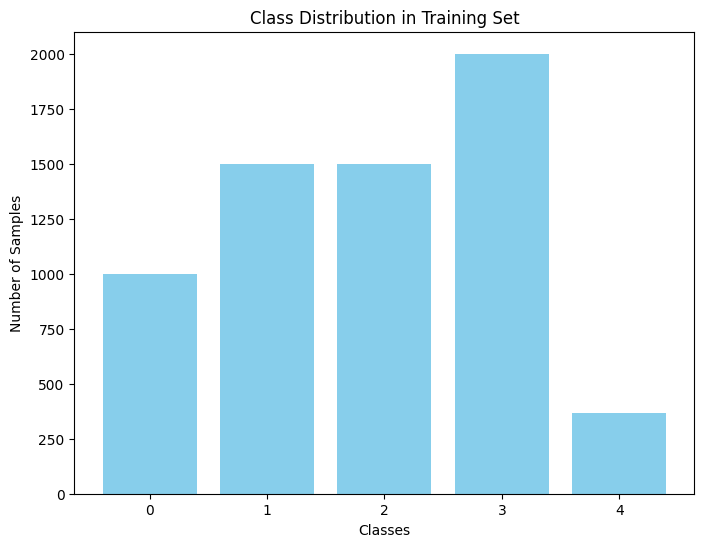

In [4]:
# Cell X: Analyze Class Distribution
import matplotlib.pyplot as plt

# Count of samples per class
class_counts = train_generator.classes
class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
plt.bar(class_names, [np.sum(class_counts == i) for i in range(len(class_names))], color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.show()

In [5]:
# Cell 12: Create Separate Generators for Minority Classes
import os

# Define the target size and batch size
target_size = (96, 96)
batch_size = 64

# Initialize data augmentation for minority classes
minority_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    shear_range=0.2,
    fill_mode='nearest'
)

# Paths to minority class directories
minority_classes = ['0', '4']
train_dir = 'train/'

augmented_generators = []

for cls in minority_classes:
    class_dir = os.path.join(train_dir, cls)
    if not os.path.isdir(class_dir):
        print(f"Directory for class {cls} not found. Skipping augmentation.")
        continue
    generator = minority_datagen.flow_from_directory(
        directory=train_dir,
        target_size=target_size,
        color_mode="rgb",
        batch_size=batch_size,
        class_mode="categorical",
        classes=[cls],  # Only target the minority class
        shuffle=True
    )
    augmented_generators.append(generator)

print(f"Number of augmented generators: {len(augmented_generators)}")

Found 1000 images belonging to 1 classes.
Found 369 images belonging to 1 classes.
Number of augmented generators: 2


In [6]:
# Cell Y: Compute Class Weights
from sklearn.utils import class_weight
import numpy as np

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to a dictionary
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)

Class Weights: {0: 1.2738, 1: 0.8492, 2: 0.8492, 3: 0.6369, 4: 3.4520325203252034}


In [7]:
# Cell 13: Combine Original and Augmented Generators
import itertools

# Create a combined generator
train_combined = itertools.chain(
    train_generator,
    *augmented_generators
)

# Define a generator that yields data from the combined generator
def combined_generator(combined):
    for data in combined:
        yield data

# Reset the iterator
train_combined = combined_generator(train_combined)

In [8]:
# Cell 5: Deeper CNN with Different Activation
def DeepCNN(input_shape, num_classes):
    model = Sequential(name="DeepCNN")

    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with RMSprop optimizer
    optimizer = optimizers.RMSprop(learning_rate=0.001)

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Instantiate and summarize the model
model_deep = DeepCNN(input_shape, num_classes)
model_deep.summary()

Model: "DeepCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 48, 48, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 64)        36928     
                                                           

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import LeakyReLU

def ImprovedDeepCNN(input_shape, num_classes):
    model = models.Sequential(name="ImprovedDeepCNN")
    
    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))
    
    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(LeakyReLU())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Global Average Pooling and Dense Layers
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001)))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    # Compile the model with Adam optimizer
    optimizer = optimizers.Adam(learning_rate=0.0001)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

# Instantiate and summarize the improved model
model_improved = ImprovedDeepCNN(input_shape, num_classes)
model_improved.summary()

Model: "ImprovedDeepCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)    

In [13]:
# Cell 7: Select Model
# Choose one of the models defined above
model = model_improved  # Replace with model_deep or model_improved

In [11]:
# Cell 8: Define Callbacks
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for potentially longer training
    verbose=1,
    mode='auto',
    restore_best_weights=True
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,  # Increased patience
    verbose=1,
    min_lr=1e-6
)

# Optionally, add ModelCheckpoint to save the best model
checkpoint = callbacks.ModelCheckpoint(
    'models/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

In [14]:
# Cell 9: Train the Model
# Calculate steps per epoch and validation steps
steps_per_epoch = int(np.ceil(train_generator.n / batch_size))
val_steps = int(np.ceil(validation_generator.n / batch_size))

try:
    history = model.fit(
        train_combined,
        epochs=100,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        class_weight=class_weights_dict,
        verbose=1
    )
except KeyboardInterrupt:
    print("Training interrupted.")

# Save the final model based if you chose deep or improved model
if model == model_deep:
    model.save('models/final_model_deep.keras')
else:
    model.save('models/final_model_improved.keras')

Epoch 1/100
100/100 [==============================] - 15s 139ms/step - loss: 1.8600 - accuracy: 0.2233 - val_loss: 1.7217 - val_accuracy: 0.6897 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - 12s 125ms/step - loss: 1.8071 - accuracy: 0.2751 - val_loss: 1.5859 - val_accuracy: 0.6897 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - 13s 127ms/step - loss: 1.7733 - accuracy: 0.3085 - val_loss: 1.5594 - val_accuracy: 0.6897 - lr: 1.0000e-04
Epoch 4/100
100/100 [==============================] - 13s 126ms/step - loss: 1.7805 - accuracy: 0.3135 - val_loss: 1.5363 - val_accuracy: 0.6890 - lr: 1.0000e-04
Epoch 5/100
100/100 [==============================] - 12s 125ms/step - loss: 1.7460 - accuracy: 0.3537 - val_loss: 1.5765 - val_accuracy: 0.5882 - lr: 1.0000e-04
Epoch 6/100
100/100 [==============================] - 13s 128ms/step - loss: 1.7442 - accuracy: 0.3632 - val_loss: 1.5315 - val_accuracy: 0.5860 - lr: 1.0000e-04
Epoch 7/100
100/100 [=

In [15]:
from tensorflow.keras.layers import Input, Average
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.models import load_model

model_deep = load_model('models/final_model_deep.keras')
model_improved = load_model('models/final_model_improved.keras')

input_shape_deep = model_deep.input_shape[1:]  # Exclude batch size
input_shape_improved = model_improved.input_shape[1:]

assert input_shape_deep == input_shape_improved, "Input shapes of both models must be the same."

# Create an input layer that matches the input shape
input_layer = Input(shape=input_shape_deep)

# Get predictions from both models
preds_deep = model_deep(input_layer)
preds_improved = model_improved(input_layer)

# Average the outputs
averaged_preds = Average()([preds_deep, preds_improved])

# Create the combined model
combined_model = Model(inputs=input_layer, outputs=averaged_preds)

# Compile the combined model
combined_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

# Save the combined model
combined_model.save('models/combined_model.keras')

# Cell 11: Evaluate the Model
# Load the combined model
combined_model = load_model('models/combined_model.keras')

# Evaluate the model on the validation set
val_loss, val_acc = combined_model.evaluate(validation_generator, verbose=1)
print(f"Validation Accuracy: {val_acc:.4f}")

43/43 [==============================] - 2s 31ms/step - loss: 1.3432 - accuracy: 0.6904
Validation Accuracy: 0.6904


In [16]:
# Cell 10: Evaluate the Model
# Load the best saved model
best_model = load_model('models/combined_model.keras')

# Evaluate on validation data
val_steps = int(np.ceil(validation_generator.n / batch_size))
loss, acc = best_model.evaluate(validation_generator, steps=val_steps, verbose=1)
print(f'Loss: {loss:.4f}')
print(f'Accuracy: {acc:.4f}')

43/43 [==============================] - 2s 31ms/step - loss: 1.3432 - accuracy: 0.6904
Loss: 1.3432
Accuracy: 0.6904


In [17]:
# Cell 11: Classification Report
preds = best_model.predict(validation_generator, steps=val_steps, verbose=0)
Ypred = np.argmax(preds, axis=1)
Ytest = validation_generator.classes  # Ensure shuffle=False in validation_generator

print(classification_report(Ytest, Ypred, target_names=classnames, digits=3))

              precision    recall  f1-score   support

           0      0.286     0.165     0.210       133
           1      0.442     0.404     0.422       275
           2      0.516     0.490     0.503       406
           3      0.809     0.822     0.815      1896
           4      0.073     0.205     0.107        39

    accuracy                          0.690      2749
   macro avg      0.425     0.417     0.411      2749
weighted avg      0.693     0.690     0.691      2749



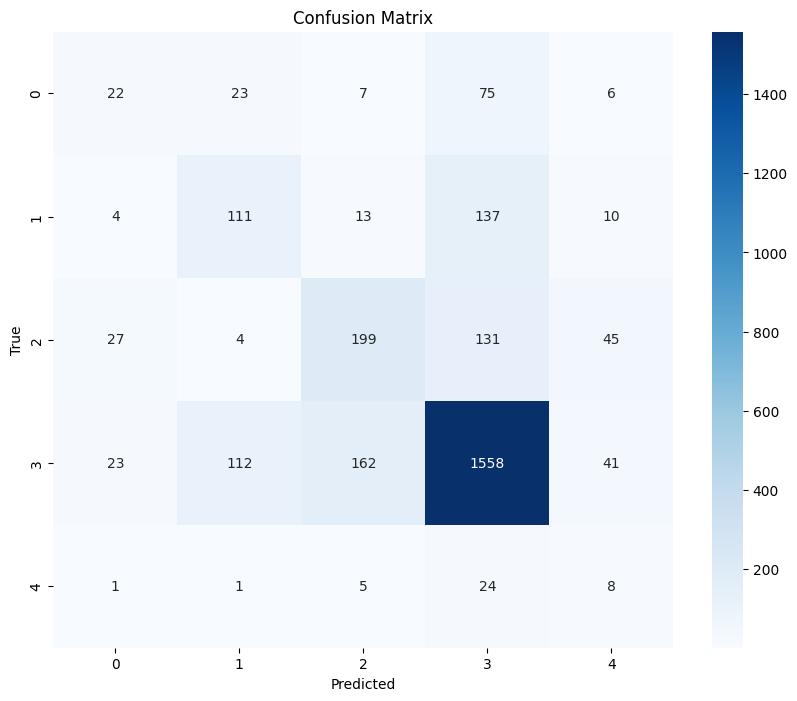

In [18]:
# Cell 12: Confusion Matrix
cm = confusion_matrix(Ytest, Ypred)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classnames, yticklabels=classnames, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Cell 13: Text-Based Confusion Matrix
conf = []
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        if i != j and cm[i][j] > 0:
            conf.append([i, j, cm[i][j]])

conf = np.array(conf)
conf = conf[np.argsort(-conf[:, 2])]  # Sort by descending error count

print(f'{"True":<16} {"Predicted":<16} {"Errors":<10} {"Error %":<10}')
print('-' * 60)
for k in conf:
    true_class = classnames[int(k[0])]
    pred_class = classnames[int(k[1])]
    errors = int(k[2])
    error_pct = (errors / validation_generator.n) * 100
    print(f'{true_class:<16} -> {pred_class:<16} {errors:<10} {error_pct:.2f}%')

True             Predicted        Errors     Error %   
------------------------------------------------------------
3                -> 2                162        5.89%
1                -> 3                137        4.98%
2                -> 3                131        4.77%
3                -> 1                112        4.07%
0                -> 3                75         2.73%
2                -> 4                45         1.64%
3                -> 4                41         1.49%
2                -> 0                27         0.98%
4                -> 3                24         0.87%
3                -> 0                23         0.84%
0                -> 1                23         0.84%
1                -> 2                13         0.47%
1                -> 4                10         0.36%
0                -> 2                7          0.25%
0                -> 4                6          0.22%
4                -> 2                5          0.18%
1                ->

In [20]:
# Cell 9: Model Deployment with Gymnasium (Final Revised for Continuous Actions)
import numpy as np
from gymnasium.wrappers import RecordVideo

def play(env, model, predefined_actions):
    seed = 2000
    obs, _ = env.reset(seed=seed)

    # Drop initial frames with no action
    no_action = predefined_actions[0]  # [0.0, 0.0, 0.0]
    for _ in range(50):
        obs, _, _, _, _ = env.step(no_action)

    done = False
    while not done:
        # Preprocess the observation
        img = preprocess_observation(obs, target_size)
        p = model.predict(np.expand_dims(img, axis=0))  # Shape: (1, 5)
        predicted_class = np.argmax(p)  # Integer 0-4

        # Map the predicted class to a predefined action
        action = predefined_actions.get(predicted_class, predefined_actions[0])  # Array

        # Ensure the action is a float32 NumPy array
        action = action.astype(np.float32)

        # Step the environment with the action
        obs, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

    env.close()

def preprocess_observation(obs, target_size):
    from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

    # Convert observation to PIL Image
    img = array_to_img(obs)
    # Resize image
    img = img.resize(target_size)
    # Convert to array and normalize
    img = img_to_array(img) / 255.0
    return img

# Define predefined actions (Continuous)
predefined_actions = {
    0: np.array([0.0, 0.0, 0.0], dtype=np.float32),  # No Action
    1: np.array([-1.0, 0.0, 0.0], dtype=np.float32), # Steer Left
    2: np.array([1.0, 0.0, 0.0], dtype=np.float32),  # Steer Right
    3: np.array([0.0, 1.0, 0.0], dtype=np.float32),  # Accelerate (Gas)
    4: np.array([0.0, 0.0, 1.0], dtype=np.float32),  # Brake
    # Add more actions as needed
}

# Initialize the environment without 'continuous' parameter
env_arguments = {
    'domain_randomize': False,
    'render_mode': 'rgb_array'
}

env_name = 'CarRacing-v3'
env = gym.make(env_name, **env_arguments)

# Wrap the environment to record videos
video_dir = 'video_recordings'  # Specify the directory to save video recordings
env = RecordVideo(env, video_dir)

print("Environment:", env_name)
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

# Play the game using the trained model
play(env, best_model, predefined_actions)
#play(env, best_model_regression, predefined_actions)

c:\Users\andri\miniconda3\envs\tf\lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\andri\Documents\GitHub\Homework-2\video_recordings folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Environment: CarRacing-v3
Action space: Box([-1.  0.  0.], 1.0, (3,), float32)
Observation space: Box(0, 255, (96, 96, 3), uint8)
1/1 [==============================] - 0s 19ms/step


# (Optional Approach) Deep Learning Model

In [5]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.layers import LeakyReLU
import random
from collections import deque
import cv2
import os

# Suppress TensorFlow warnings for cleaner output
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# =========================
# 1. Define Predefined Actions
# =========================
predefined_actions = {
    0: np.array([0.0, 0.0, 0.0], dtype=np.float32),  # No Action
    1: np.array([-1.0, 0.0, 0.0], dtype=np.float32), # Steer Left
    2: np.array([1.0, 0.0, 0.0], dtype=np.float32),  # Steer Right
    3: np.array([0.0, 1.0, 0.0], dtype=np.float32),  # Accelerate (Gas)
    4: np.array([0.0, 0.0, 1.0], dtype=np.float32),  # Brake
}

# =========================
# 2. Define the Gym Environment
# =========================
class CarDrivingEnv(gym.Env):
    """
    Custom Gymnasium Environment for Car Driving.
    Replace the placeholder methods with your actual environment logic.
    """
    def __init__(self):
        super(CarDrivingEnv, self).__init__()
        # Define action space
        self.action_space = spaces.Discrete(len(predefined_actions))
        # Define observation space for preprocessed frames (grayscale)
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(84, 84, 1), dtype=np.float32)
        self.max_steps = 1000
        self.current_step = 0

    def reset(self):
        """
        Reset the environment to an initial state and return the initial observation.
        """
        self.current_step = 0
        initial_observation = self._get_initial_observation()
        preprocessed = preprocess_observation(initial_observation)
        return preprocessed

    def step(self, action):
        """
        Apply the action to the environment and return the next observation, reward, done, and info.
        """
        action_vector = predefined_actions[action]
        next_observation, raw_reward, done, info = self._apply_action(action_vector)
        preprocessed = preprocess_observation(next_observation)
        self.current_step += 1

        # Example termination conditions
        if self.current_step >= self.max_steps:
            done = True

        # Compute the reward
        reward = compute_reward(info, done)

        return preprocessed, reward, done, info

    def render(self, mode='human'):
        """
        Render the environment to the screen.
        """
        pass  # Implement rendering logic if needed

    def _get_initial_observation(self):
        """
        Return the initial observation.
        Replace this with your environment's initial state.
        """
        # Placeholder: return a dummy image
        return np.zeros((240, 320, 3), dtype=np.uint8)

    def _apply_action(self, action_vector):
        """
        Apply the action to the environment.
        Replace this with your environment's action application logic.
        """
        # Placeholder: return a dummy next state, reward, done, and info
        next_observation = np.zeros((240, 320, 3), dtype=np.uint8)
        raw_reward = 1.0  # Placeholder reward
        done = False
        info = {
            'collision': False,
            'off_track': False,
            'speed': 0.0
        }
        return next_observation, raw_reward, done, info

# =========================
# 3. Preprocessing Functions
# =========================
def preprocess_observation(observation):
    """
    Preprocess the observation by converting to grayscale, resizing, and normalizing.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
    # Resize to 84x84
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)
    # Normalize pixel values
    normalized = resized / 255.0
    # Expand dimensions to add channel axis
    return np.expand_dims(normalized, axis=2)  # Shape: (84, 84, 1)

def compute_reward(info, done):
    """
    Compute the reward based on the current state.
    """
    if done:
        if info.get('collision', False):
            return -100.0  # Collision penalty
        elif info.get('off_track', False):
            return -100.0  # Off track penalty
        else:
            return 100.0  # Success reward
    else:
        reward = 1.0  # Reward for staying on track
        # Optionally, add more components (e.g., speed)
        reward += info.get('speed', 0.0) * 0.1
        return reward

# =========================
# 4. Frame Stacking Wrapper
# =========================
class FrameStackEnv(gym.Wrapper):
    """
    Gymnasium environment wrapper to stack consecutive frames.
    """
    def __init__(self, env, stack_size=4):
        super(FrameStackEnv, self).__init__(env)
        self.stack_size = stack_size
        self.frames = deque(maxlen=stack_size)
        # Update the observation space to reflect stacked frames
        low = np.repeat(env.observation_space.low, stack_size, axis=2)
        high = np.repeat(env.observation_space.high, stack_size, axis=2)
        self.observation_space = spaces.Box(low=0.0, high=1.0, 
                                            shape=(env.observation_space.shape[0], 
                                                   env.observation_space.shape[1], 
                                                   env.observation_space.shape[2] * stack_size), 
                                            dtype=np.float32)

    def reset(self):
        observation = self.env.reset()
        for _ in range(self.stack_size):
            self.frames.append(observation)
        return self._get_observation()

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        self.frames.append(observation)
        return self._get_observation(), reward, done, info

    def _get_observation(self):
        return np.concatenate(list(self.frames), axis=2)

# =========================
# 5. Replay Buffer
# =========================
class ReplayBuffer:
    def __init__(self, max_size=100000):
        self.buffer = deque(maxlen=max_size)

    def add(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

# =========================
# 6. DQN Model Architecture
# =========================
def build_dqn_model(input_shape, num_actions):
    """
    Build a Convolutional Neural Network for the DQN agent.
    """
    model = models.Sequential(name="DQN_Model")
    
    # Convolutional Layers
    model.add(layers.Conv2D(32, (8, 8), strides=4, activation='relu', input_shape=input_shape))
    model.add(layers.Conv2D(64, (4, 4), strides=2, activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), strides=1, activation='relu'))
    
    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    
    # Output Layer
    model.add(layers.Dense(num_actions, activation='linear'))
    
    return model

# =========================
# 7. DQN Agent
# =========================
class DQNAgent:
    def __init__(self, input_shape, num_actions, learning_rate=1e-4, gamma=0.99,
                 epsilon=1.0, epsilon_min=0.1, epsilon_decay=1e-6, batch_size=32,
                 replay_buffer_size=100000, target_update_freq=1000):
        
        self.num_actions = num_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.learn_step_counter = 0
        
        # Main and Target Networks
        self.model = build_dqn_model(input_shape, num_actions)
        self.target_model = build_dqn_model(input_shape, num_actions)
        self.target_model.set_weights(self.model.get_weights())
        
        # Optimizer and Loss Function
        self.optimizer = optimizers.Adam(learning_rate=learning_rate)
        self.loss_function = tf.keras.losses.Huber()
        
        # Replay Buffer
        self.replay_buffer = ReplayBuffer(max_size=replay_buffer_size)
    
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_actions)
        state = np.expand_dims(state, axis=0)  # Add batch dimension
        q_values = self.model.predict(state, verbose=0)
        return np.argmax(q_values[0])
    
    def store_experience(self, state, action, reward, next_state, done):
        self.replay_buffer.add((state, action, reward, next_state, done))
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
    
    def train_step(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        batch = self.replay_buffer.sample(self.batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        
        # Predict Q-values for next states using target network
        target_q = self.target_model.predict(next_states, verbose=0)
        max_target_q = np.max(target_q, axis=1)
        
        # Compute target values
        targets = rewards + (1 - dones) * self.gamma * max_target_q
        
        with tf.GradientTape() as tape:
            q_values = self.model(states, training=True)
            # Gather the Q-values for the taken actions
            action_masks = tf.one_hot(actions, self.num_actions)
            q_action = tf.reduce_sum(q_values * action_masks, axis=1)
            loss = self.loss_function(targets, q_action)
        
        # Backpropagation
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        # Update epsilon
        self.update_epsilon()
        
        # Update target network
        self.learn_step_counter += 1
        if self.learn_step_counter % self.target_update_freq == 0:
            self.target_model.set_weights(self.model.get_weights())
    
    def save_model(self, path):
        self.model.save_weights(path)
        print(f"Model weights saved to {path}")
    
    def load_model(self, path):
        self.model.load_weights(path)
        self.target_model.set_weights(self.model.get_weights())
        print(f"Model weights loaded from {path}")

# =========================
# 8. Training and Evaluation Functions
# =========================
def train_dqn(env, agent, num_episodes=1000, max_steps=1000, save_every=100, save_path='dqn_final_model.h5'):
    """
    Train the DQN agent in the given environment.
    """
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False
        
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            
            agent.store_experience(state, action, reward, next_state, done)
            agent.train_step()
            
            state = next_state
            
            if done:
                break
        
        print(f"Episode {episode}/{num_episodes} - Total Reward: {total_reward:.2f} - Epsilon: {agent.epsilon:.4f}")
        
        # Save the model at regular intervals
        if episode % save_every == 0:
            agent.save_model(f'dqn_model_episode_{episode}.h5')
    
    # Save the final model
    agent.save_model(save_path)

def evaluate_agent(env, agent, num_episodes=10, max_steps=1000):
    """
    Evaluate the trained DQN agent without exploration.
    """
    total_rewards = []
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0  # Disable exploration
    
    for episode in range(1, num_episodes + 1):
        state = env.reset()
        total_reward = 0
        done = False
        
        for step in range(max_steps):
            action = agent.select_action(state)
            next_state, reward, done, info = env.step(action)
            total_reward += reward
            state = next_state
            if done:
                break
        
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode}/{num_episodes} - Total Reward: {total_reward:.2f}")
    
    agent.epsilon = original_epsilon  # Restore original epsilon
    avg_reward = np.mean(total_rewards)
    print(f"Average Evaluation Reward over {num_episodes} episodes: {avg_reward:.2f}")
    return avg_reward

# =========================
# 9. Main Execution
# =========================

# Initialize Environment and Wrap with FrameStack
env = CarDrivingEnv()
env = FrameStackEnv(env, stack_size=4)

# Define Input Shape and Number of Actions
input_shape = env.observation_space.shape  # Should be (84, 84, 4)
num_actions = env.action_space.n  # 5

print(f"Input Shape: {input_shape}")  # For debugging

# Initialize DQN Agent
agent = DQNAgent(
    input_shape=input_shape,
    num_actions=num_actions,
    learning_rate=1e-4,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.1,
    epsilon_decay=1e-6,
    batch_size=32,
    replay_buffer_size=100000,
    target_update_freq=1000
)

# Train the Agent
train_dqn(env, agent, num_episodes=1000, max_steps=1000, save_every=100, save_path='dqn_final_model.h5')

# Evaluate the Trained Agent
evaluate_agent(env, agent, num_episodes=10, max_steps=1000)

Input Shape: (84, 84, 4)
Episode 1/1000 - Total Reward: 1099.00 - Epsilon: 0.9990
Episode 2/1000 - Total Reward: 1099.00 - Epsilon: 0.9980
Episode 3/1000 - Total Reward: 1099.00 - Epsilon: 0.9970
Episode 4/1000 - Total Reward: 1099.00 - Epsilon: 0.9960
Episode 5/1000 - Total Reward: 1099.00 - Epsilon: 0.9950
Episode 6/1000 - Total Reward: 1099.00 - Epsilon: 0.9940
Episode 7/1000 - Total Reward: 1099.00 - Epsilon: 0.9930
Episode 8/1000 - Total Reward: 1099.00 - Epsilon: 0.9920
Episode 9/1000 - Total Reward: 1099.00 - Epsilon: 0.9910
Episode 10/1000 - Total Reward: 1099.00 - Epsilon: 0.9900
Episode 11/1000 - Total Reward: 1099.00 - Epsilon: 0.9890
Episode 12/1000 - Total Reward: 1099.00 - Epsilon: 0.9880
Episode 13/1000 - Total Reward: 1099.00 - Epsilon: 0.9870
Episode 14/1000 - Total Reward: 1099.00 - Epsilon: 0.9860
Episode 15/1000 - Total Reward: 1099.00 - Epsilon: 0.9850
Episode 16/1000 - Total Reward: 1099.00 - Epsilon: 0.9840
Episode 17/1000 - Total Reward: 1099.00 - Epsilon: 0.983

KeyboardInterrupt: 